## 掛載雲端硬碟


In [22]:
# from google.colab import drive
# drive.mount('/content/drive')

## 更改檔案所在路徑

In [23]:
# # Change to your own folder !!!
# %cd /content/drive/MyDrive/Colab\ Notebooks/EAI_Lab4_2023

## Import library

In [24]:
from __future__ import print_function
import os
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from models import vgg

## 設定超參數

In [25]:
TRAIN_BATCH_SIZE = 100
TEST_BATCH_SIZE = 1000
EPOCHS = 20
LEARNING_RATE = 0.1
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
LOG_INTERVAL = 100
CUDA = True
SEED = 1

RESUME = True
START_EPOCH = 0

PRUNE_PERCENT = 0.5
PRUNE_PATH = f'/ssd6/Roy/EAI_Lab4_2024_題目/model_prune_{PRUNE_PERCENT}.pth'
PRUNE_FINETUNE_PATH = f'/ssd6/Roy/EAI_Lab4_2024_題目/model_prune_finetune_{PRUNE_PERCENT}.pth'


#### 檢查是否檢查是否可使用GPU

In [26]:
if(torch.cuda.is_available()):
    CUDA = True
    kwargs = {'num_workers': 1, 'pin_memory': True}
    torch.cuda.manual_seed(SEED)
else:
    CUDA = False
    kwargs = {}


## 下載資料集


這裡將訓練集做Augmentation(Pad, RandCrop, Random)，測試集不用做Augmentation

In [27]:
#### DATASET ####
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Pad(4),
                       transforms.RandomCrop(32),
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=TRAIN_BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=TEST_BATCH_SIZE, shuffle=True, **kwargs)

Files already downloaded and verified


## 載入剪枝後的網路與權重

In [28]:
model = None
if(RESUME):
  checkpoint = torch.load(PRUNE_PATH)
  model = vgg(cfg=checkpoint['cfg'])
  model.load_state_dict(checkpoint['state_dict'])

  print('RESUME PRUNE MODEL')

if CUDA:
    model.cuda()

RESUME PRUNE MODEL


/tmp/ipykernel_3168698/2756754050.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(PRUNE_PATH)


## 設定Optimizer，這裡使用Stocastic Gradient Descent with

In [29]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

## 定義訓練跟測試函數

In [30]:
# 注意: 需自行撰寫儲存每個epoch之train acc的code，以便後續繪製train acc結果圖!
train_acc_list = []  # 用於儲存每個 epoch 的訓練準確率

#### 訓練函數 #####
def train(epoch):
    model.train()
    train_correct = 0
    train_total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        if CUDA:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)

        pred = output.data.max(1, keepdim=True)[1]
        train_correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
        train_total += target.size(0)

        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.1f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))
    
    # 計算當前 epoch 的訓練準確率並儲存
    train_accuracy = train_correct / train_total
    train_acc_list.append(train_accuracy)
    print(f'Train Accuracy for Epoch {epoch}: {train_accuracy * 100:.2f}%')


#### 測試函數 ####
def test():
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
      for data, target in test_loader:
          if CUDA:
              data, target = data.cuda(), target.cuda()
          data, target = Variable(data), Variable(target)
          output = model(data)
          test_loss += F.cross_entropy(output, target, reduction='sum').data.item()
          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).cpu().sum()

      test_loss /= len(test_loader.dataset)
      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset),
          100. * correct / len(test_loader.dataset)))
      return correct / float(len(test_loader.dataset))

best_prec1 = 0.
for epoch in range(START_EPOCH, EPOCHS):
    # Learning Rate在0.5EPOCHS與0.75EPOCHS調整為原本1/10
    if epoch in [EPOCHS*0.5, EPOCHS*0.75]:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1
    train(epoch)
    prec1 = test()

    # 儲存模型權重，方便做後續剪枝,後續訓練
    if(prec1 > best_prec1):
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'optimizer': optimizer.state_dict(),
        }, PRUNE_FINETUNE_PATH)

    best_prec1 = max(prec1, best_prec1)

print('\n TRAIN PRUNED MODEL DONE!')


Train Epoch: 0 [0/50000 (0.0%)]	Loss: 0.026769
Train Epoch: 0 [10000/50000 (20.0%)]	Loss: 0.452741
Train Epoch: 0 [20000/50000 (40.0%)]	Loss: 0.319315
Train Epoch: 0 [30000/50000 (60.0%)]	Loss: 0.306196
Train Epoch: 0 [40000/50000 (80.0%)]	Loss: 0.305088
Train Accuracy for Epoch 0: 89.38%

Test set: Average loss: 0.5087, Accuracy: 8418/10000 (84.2%)

Train Epoch: 1 [0/50000 (0.0%)]	Loss: 0.220949
Train Epoch: 1 [10000/50000 (20.0%)]	Loss: 0.363606
Train Epoch: 1 [20000/50000 (40.0%)]	Loss: 0.316303
Train Epoch: 1 [30000/50000 (60.0%)]	Loss: 0.317777
Train Epoch: 1 [40000/50000 (80.0%)]	Loss: 0.253229
Train Accuracy for Epoch 1: 91.00%

Test set: Average loss: 0.4360, Accuracy: 8680/10000 (86.8%)

Train Epoch: 2 [0/50000 (0.0%)]	Loss: 0.258212
Train Epoch: 2 [10000/50000 (20.0%)]	Loss: 0.213069
Train Epoch: 2 [20000/50000 (40.0%)]	Loss: 0.235742
Train Epoch: 2 [30000/50000 (60.0%)]	Loss: 0.232902
Train Epoch: 2 [40000/50000 (80.0%)]	Loss: 0.278190
Train Accuracy for Epoch 2: 91.60%

Tes

## 繪製Fine-tuning結果圖


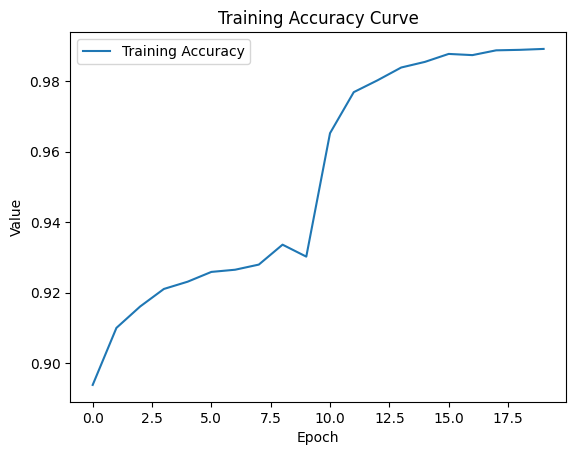

In [31]:
#繪製Fine-tuning結果圖
# 在訓練過程完成後，可以使用 train_acc_list 繪製訓練準確率
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(START_EPOCH, EPOCHS), train_acc_list, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Accuracy Curve')
plt.legend()
plt.show()